In [5]:
# much of this code, particularly the encoder decoder code, is taken from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# the rest is adapted for this project but is still pretty similar

from io import open
import unicodedata
import string
import re
import random
import os

import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [22]:
# for start and end of string
SOS_token = 0
EOS_token = 1

# Alphabet class (works with both pinyin and English)
class Alphabet:
    def __init__(self, name):
        self.name = name
        self.letter2index = {}
        self.letter2count = {}
        self.index2letter = {0: "SOS", 1: "EOS"}
        self.n_letters = 2
        
    def add_name(self, name):
        """
        Adds the characters of a name to the alphabet by iterating over them
        and updating the appropriate counts
        """
        for letter in name: # for pinyin we can keep the space as a letter and see if this thing learns syllable boundries
            if letter not in self.letter2index:
                self.letter2index[letter] = self.n_letters
                self.letter2count[letter] = 1
                self.index2letter[self.n_letters] = letter
                self.n_letters += 1
            else:
                self.letter2count[letter] += 1


In [49]:
data_file = os.path.join("..", "data", "EnglishChineseNames_uniq.txt")

def normalize(s):
    """
    Right now just converts a string to lowercase but could be something more later
    (such as removing spaces)
    """
    s = re.sub(r"([-.·])", r"", s) # remove punctuation that seems to have seeped in (including chinese dash)
    return s.lower()

def read_alphabets():
    """
    Creates two alphabets, one for English / Romanized names and the other for pinyin
    Iterates through data file to initialize those alphabets
    """
    input_alph = Alphabet("English")
    output_alph = Alphabet("Pinyin")
    pairs = []
    
    df = pd.read_csv(data_file)
    for row_i, row in df.iterrows():
        english, _, _, pinyin = row
        english = normalize(english)
        pinyin = normalize(pinyin)
        input_alph.add_name(english)
        output_alph.add_name(pinyin) # includes spaces
        pairs.append([english, pinyin])
     
    print("Input names have: {} characters".format(input_alph.n_letters))
    print("Output names have: {} characters".format(output_alph.n_letters))


    return input_alph, output_alph, pairs
        
eng_alph, pin_alph, pairs = read_alphabets()

Input names have: 28 characters
Output names have: 49 characters


In [61]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)#, device=device)

In [62]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # still need an embedding
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # assume because we have 1-d data
        
    def forward(self, x, hidden):
        output = self.embedding(x).view(1, 1, -1)
        output = F.relu(output) # regularization thing
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0])) # output is only going to have a single thing, so this is legal i guess
        return output, hidden
     

In [63]:
def indexesFromName(alphabet, name):
    return [alphabet.letter2index[l] for l in name]

def tensorFromName(alphabet, name):
    indexes = indexesFromName(alphabet, name)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromName(eng_alph, pair[0])
    target_tensor = tensorFromName(pin_alph, pair[1])
    return (input_tensor, target_tensor)


In [54]:
# how often we use the target input as input to our decoder rather than our decoder's guess
# while training 
teacher_forcing_ratio = 0.5 
MAX_LENGTH = 20


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
         criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden() # just 0's
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)
    
    loss = 0 # mission accomplished ;)
    
    # actually run the thing that encodes
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    
    # now its decoder time - this part changes somewhat if you add attention
    decoder_input = torch.tensor([[SOS_token]])
    decoder_hidden = encoder_hidden # no need for an init function
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # target is next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # bc we're using teacher focing
            
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1) # returns a tuple of the largest value and its index as tensors
            decoder_input = topi.squeeze().detach() # I'm not totally sure what this does
            loss += criterion(decoder_output, target_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break # we're done with this sentence - we don't have to do this above bc it goes to the end of the string automatically
    
    
    # backprop
    loss.backward()
    
    # run SGD which is in the encoder/decoder_optimizer object
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/target_length # not sure what this is, but we can see I guess


In [55]:
# copied directly for profiling...
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [56]:
# Actually do the training:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate = 0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)] # only this many?
    criterion = nn.NLLLoss() # this is... negative log likelihood loss
                             # it's the same as cross-entropy loss bc of the log softmax in the last layer
    
    for iter_i in range(1, n_iters + 1):
        training_pair = training_pairs[iter_i -1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter_i % print_every == 0:
            print_loss_avg = print_loss_total / print_every # calc avg loss
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter_i / n_iters),
                                         iter_i, iter_i / n_iters * 100, print_loss_avg))
        # for plotting loss
        if iter_i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [57]:
%matplotlib inline

#shamelessly copied from tutorial... yikes
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [72]:
# Same as training, just no targets - just rum the thing through the network

def evaluate(encoder, decoder, name, max_len=MAX_LENGTH):
    with torch.no_grad(): # not totally sure what this does tbh - probably stops from updating gradients like we do in training because we are done with training
        input_tensor = tensorFromName(eng_alph, name)
        input_length = input_tensor.size(0) # just the size of the first dimension
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_len, encoder.hidden_size)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0] # is a vector 
        
        # decoder - would have to change if added attention
        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden
        decoded_name = []
        
        for di in range(max_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            
            # transliterate to actual words 
            if topi.item() == EOS_token:
                decoded_name.append("<EOS>")
                break
            else:
                decoded_name.append(pin_alph.index2letter[topi.item()])
            
            decoder_input = topi.squeeze().detach()
            
            
        return decoded_name

In [75]:
def evaluateRandomLines(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_name = evaluate(encoder, decoder, pair[0])
        print('<', ''.join(output_name[:-1]))
        print()

0m 35s (- 8m 10s) (5000 6%) 1.0000
1m 9s (- 7m 30s) (10000 13%) 1.0000
1m 44s (- 6m 57s) (15000 20%) 1.0000
2m 17s (- 6m 18s) (20000 26%) 1.0000
2m 49s (- 5m 39s) (25000 33%) 1.0000
3m 21s (- 5m 2s) (30000 40%) 1.0000
3m 54s (- 4m 27s) (35000 46%) 1.0000
4m 24s (- 3m 51s) (40000 53%) 1.0000
4m 55s (- 3m 17s) (45000 60%) 1.0000
5m 26s (- 2m 43s) (50000 66%) 1.0000
5m 57s (- 2m 9s) (55000 73%) 1.0000
6m 29s (- 1m 37s) (60000 80%) 1.0000
6m 59s (- 1m 4s) (65000 86%) 1.0000
7m 32s (- 0m 32s) (70000 93%) 1.0000
8m 3s (- 0m 0s) (75000 100%) 1.0000


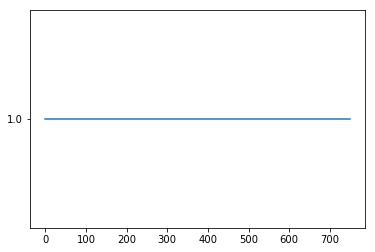

In [64]:
# now actually do the thing!
hidden_size = 64
encoder1 = EncoderRNN(eng_alph.n_letters, hidden_size)
decoder1 = DecoderRNN(hidden_size, pin_alph.n_letters)

trainIters(encoder1, decoder1, 75000, print_every=5000)

In [76]:
evaluateRandomLines(encoder1, decoder1, 10)

> matthew
= mǎ xiū
< mǎ xiē sī

> maurice
= mó lǐ sī
< mù lǐ sī

> laurel
= luó ruì ěr
< láo ěr ěr

> iban
= yī bāng
< yī bāng

> ulysses
= yóu lǐ xī sī
< yiá lì sī

> jackie
= jié kè
< jié jī

> ted
= tài dé
< tài dé

> ina
= ài nà
< ài nà

> veronica
= wéi luō ní kǎ
< wéi lēi nà

> darian
= dá lǐ ān
< dá lǐ ān



In [83]:
import datetime
def save_model(encoder, decoder):
    torch.save(encoder.state_dict(), os.path.join("..", "models", "encoder-{date:%Y-%m-%d-%H:%M:%S}".format(date=datetime.datetime.now())))
    torch.save(decoder.state_dict(), os.path.join("..", "models", "decoder-{date:%Y-%m-%d-%H:%M:%S}".format(date=datetime.datetime.now())))

save_model(encoder1, decoder1)

In [84]:
def load_model(encoder_path, decoder_path):
    encoder1 = EncoderRNN(eng_alph.n_letters, hidden_size)
    decoder1 = DecoderRNN(hidden_size, pin_alph.n_letters)
    encoder1.load_state_dict(torch.load(encoder_path))
    decoder1.load_state_dict(torch.load(decoder_path))
    return encoder1, decoder1

In [47]:
sorted(pin_alph.index2letter.values())

[' ',
 'EOS',
 'SOS',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'w',
 'x',
 'y',
 'z',
 'à',
 'á',
 'è',
 'é',
 'ì',
 'í',
 'ò',
 'ó',
 'ù',
 'ú',
 'ü',
 'ā',
 'ē',
 'ě',
 'ī',
 'ō',
 'ū',
 'ǎ',
 'ǐ',
 'ǒ',
 'ǔ',
 'ǜ']

In [53]:
#df = pd.read_csv(data_file)
max([len(x) for x in df['first name']])

11

AttributeError: 'Series' object has no attribute 'contains'